<a id='Introduction'></a>
# Introduction

[Introduction](#Introduction) [Imports](#Imports) [Helper](#Helper)  >>  
[Data](#data) [Model](#model)  [Initial Data](#initial) [Sampling Initial Data](#sampling)  >>
[Bayesian Optimization](#bayesian) [Imports BO](#imports_bo) [BO Search](#bo_search) >> [Epochs Choice](#epochs) [Final Model](#final) [Confusion Matrix](#confusion_matrix)

This is the final project for Machine Learning & Artificial Intelligence. The goal is to apply Bayesian Optimization training, a classifier using a neural network with CNN that can diagnose patients with pneumonia. 

The chosen dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). The dataset comprehends lung X-ray images from children, and the goal is to train a classifier that is able to diagnose patients for pneumonia. 

> Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, V2, doi: 10.17632/rscbjbr9sj.2

The dataset has high-resolution images, and it has been pre-cleaned and labelled by specialists. It comprehends 5.856 files with a size of 1.15GB.

The original data was provided with an original split for training, validation and testing. However, this author decided to merge all the files again and do a new split - the files on the original division for training and testing needed to be more.



<a id='Imports'></a>
# Imports

[Introduction](#Introduction) [Imports](#Imports) [Helper](#Helper)  >>  
[Data](#data) [Model](#model)  [Initial Data](#initial) [Sampling Initial Data](#sampling)  >>
[Bayesian Optimization](#bayesian) [Imports BO](#imports_bo) [BO Search](#bo_search) >> [Epochs Choice](#epochs) [Final Model](#final) [Confusion Matrix](#confusion_matrix)

In [1]:
import cv2  # !pip install opencv-python

from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision
import torch
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import splitfolders

import torch.nn as nn  # model
import torch.nn.functional as F  # model

import torch.optim as optim  # optimizer
import time  # so we can keep track of time...


from torchinfo import summary  # exp.track
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import pickle as pkl

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import normalize,MinMaxScaler,StandardScaler
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import itertools as it
import shutil





<a id='Helper'></a>
# Helper Functions

- The function img_loader() is used by the Imagefolder function to read the data images from a specific folder. 
- imshow() just displays any requested image

In [129]:
# img = cv2.imread("some_image.pgm", cv2.IMREAD_COLOR)

def img_loader(filename):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    width = 224  #200 # lowering image resolutions 
    height = 224  #200
    dim = (width,height)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    return resized

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

def save_ckp(state, is_best, checkpoint_dir, best_model_dir):  # we can save a model with this function
    f_path = f'{checkpoint_dir}/checkpoint.pt'
    torch.save(state, f_path)
    if is_best:  # if saving best model separate
        best_fpath = f'{best_model_dir}/best_model.pt'
        shutil.copyfile(f_path, best_fpath)
        
def load_ckp(checkpoint_fpath, model, optimizer):  # loads a previously saved model.
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

- perf_check_overall is used for calculating accuracy metric, while count_classes, just counts the classes in the dataset.

In [4]:
def count_classes(loader):
    class_list = torch.Tensor()
    for data in loader:
        _, labels = data
        class_list = torch.cat((class_list, labels))
    return class_list


def perf_check_overall(net_model, test_df):
    correct = 0
    total = 0
    
    prediction_list = torch.Tensor()
    label_list = torch.Tensor()
    
    with torch.no_grad():
        for data in test_df:
            images, labels = data
            outputs = net_model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            prediction_list = torch.cat((prediction_list,predicted))
            label_list = torch.cat((label_list,labels))
                                       
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = correct / total
    recall = recall_score(label_list, prediction_list)
    f2score = fbeta_score(label_list, prediction_list, beta=2)
    print(f'Recall -> {recall}')
    print(f'Accuracy -> {accuracy}')
    print(f'f2 score -> {f2score}')
    print('Accuracy of the network w/ validation/test: %d %%' % (
        100 * accuracy))
    return accuracy, recall, f2score

In [6]:
def set_seeds(seed: int=42):
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

<a id = 'data'></a>
# Data

[Introduction](#Introduction) [Imports](#Imports) [Helper](#Helper)  >>  
[Data](#data) [Model](#model)  [Initial Data](#initial) [Sampling Initial Data](#sampling)  >>
[Bayesian Optimization](#bayesian) [Imports BO](#imports_bo) [BO Search](#bo_search) >> [Epochs Choice](#epochs) [Final Model](#final) [Confusion Matrix](#confusion_matrix)

## Dataset partitioning

The data obtained was already partitioned in training, validation and testing. However, it was found to be unsuitable, so the data has been re-unified to be split again. Using splitfolders 70% of the data has been assigned to training, 15% to validation and the remaining 15% to testing.

In [7]:
run_split_folders = False

if run_split_folders:
    splitfolders.ratio("./chest_xray_full/data/", 
                       output="partitioned_data_7", 
                       seed=1337, 
                       ratio=(.7, .15, .15), 
                       group_prefix=None, 
                       move=False)

# Copying files: 5856 files [01:44, 55.89 files/s] 

## Loading data with DataLoader

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])

- By using a DataLoader we prevent running out of memory and allow the data to be read in parallel.

In [9]:
data_train = ImageFolder(root='./partitioned_data_7/train/', loader=img_loader,
                         transform=transform)

data_val = ImageFolder(root='./partitioned_data_7/val/', loader=img_loader,
                       transform=transform)

data_test = ImageFolder(root='./partitioned_data_7/test/', loader=img_loader,
                        transform=transform)

trainloader = torch.utils.data.DataLoader(data_train, batch_size=4, 
                                          shuffle=True, num_workers=0)

valloader = torch.utils.data.DataLoader(data_val, batch_size=4, 
                                        shuffle=False, num_workers=0)

testloader = torch.utils.data.DataLoader(data_test, batch_size=4,
                                         shuffle=False, num_workers=0)

In [10]:
def count_classes(loader):
    class_list = torch.Tensor()
    for data in loader:
        _, labels = data
        class_list = torch.cat((class_list, labels))
    return class_list

if run_split_folders:
    train_labels = count_classes(trainloader)
    val_labels   = count_classes(valloader)
    test_labels  = count_classes(testloader)
    
    df_count_samples = pd.DataFrame(index=['Training', 'Validation','Test'])
    df_count_samples['Total Size'] =[len(train_labels), len(val_labels), len(test_labels)]
    df_count_samples['Class 0'] = [int(len(train_labels)-train_labels.sum()),int(len(val_labels)-val_labels.sum()),int(len(test_labels)-test_labels.sum())]
    df_count_samples['Class 1'] = df_count_samples['Total Size'] - df_count_samples['Class 0']
    df_count_samples.to_pickle('./workflow_data/df_count_samples.pkl')
else:
    df_count_samples = pd.read_pickle('./workflow_data/df_count_samples.pkl')
    
#1m40s

In [11]:
df_count_samples

,Total Size,Class 0,Class 1
Training,4099,1108,2991
Validation,877,237,640
Test,880,238,642


In [12]:
data_train.class_to_idx

{'NORMAL': 0, 'PNEUMONIA': 1}

- As we can see, the data is not balanced; the dominand class is "Class 1" - Pneumonia. That means we should look into other metrics as well besides accuracy.

In [13]:
classes_t = data_train.classes

In [14]:
dataiter = iter(trainloader)

In [17]:
images, labels = next(dataiter)

- Sampling the data:

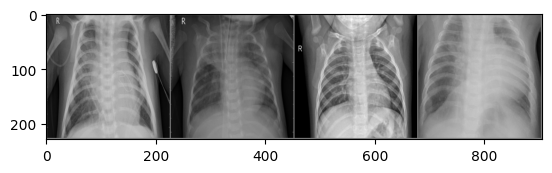

PNEUMONIA PNEUMONIA NORMAL PNEUMONIA


In [18]:
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes_t[labels[j]] for j in range(4)))

<a id = 'model'></a>
# The model

[Introduction](#Introduction) [Imports](#Imports) [Helper](#Helper)  >>  
[Data](#data) [Model](#model)  [Initial Data](#initial) [Sampling Initial Data](#sampling)  >>
[Bayesian Optimization](#bayesian) [Imports BO](#imports_bo) [BO Search](#bo_search) >> [Epochs Choice](#epochs) [Final Model](#final) [Confusion Matrix](#confusion_matrix)

## The standard model

The diagrams below illustrate the architecture of a classical LeNet-5 Network.


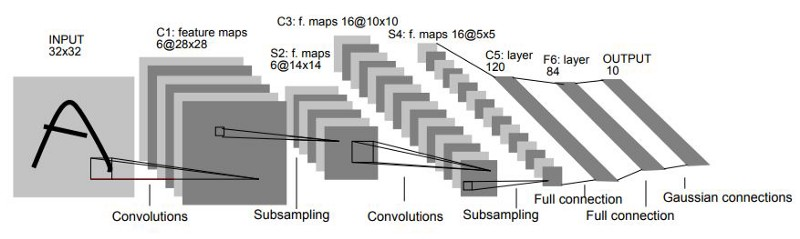

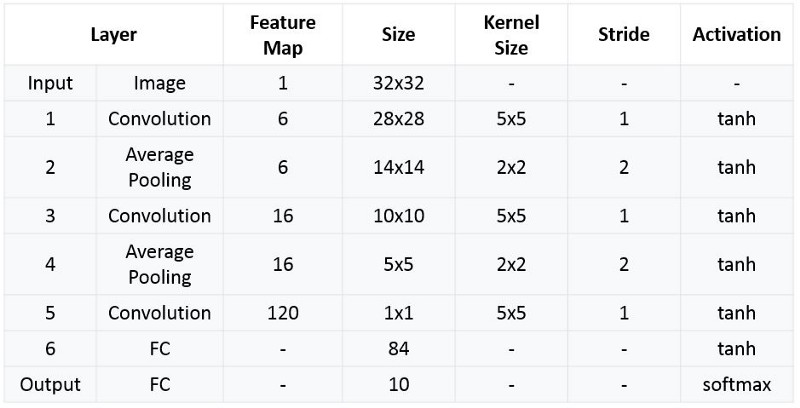

*Source: https://www.datasciencecentral.com*

LeNet-5 is a convolutional neural network (CNN) architecture developed by Yann LeCun in 1998 for handwritten digit recognition. It consists of seven layers, including two convolutional layers, two pooling layers, and two fully connected layers. The first convolutional layer extracts features using a 5x5 filter, followed by a pooling layer. The second convolutional layer extracts more complex features using a 5x5 filter, followed by another pooling layer. The extracted features are then flattened and fed into two fully connected layers, with the final layer producing the classification output. LeNet-5 played a significant role in popularizing CNNs and laid the foundation for modern deep-learning applications.

We will use the traditional LeNet-5 architecture as a prototype for a versatile model that will be enhanced through optimization.

## The versatile model

The model has been rewritten to allow for different hyperparameter definitions:
- Number of ouputs of each convolutional layer
- Kernel size used in each convolutional layer 
- Filter Size and Stride Step for MaxPool layer

That makes so far 6 parameters we will be optimizing in this project. There will be 8 parameters(including the optimizer learning rate and momentum). Also, the input layer, in our case, will consist of resized images to 224x224 pixels.

In [19]:
class LeNet(nn.Module):
    def __init__(self, conv1out=6, conv1kernel=5, filter_size=2, stride_step=2,
                 conv2out=16, conv2kernel=5, fc1_dims=(1,1,1), name=None):
        super(LeNet, self).__init__()
        if name:
            self.name = name

        self.conv1 = nn.Conv2d(1, conv1out, conv1kernel)  # * 1 input channel,12 outputs 5x5 kernel size | input_channels, output channels, filter size
        self.pool = nn.MaxPool2d(filter_size, stride_step) # ** filter size, stride size # acts the same way in each channele, it does not know the number of channels fo the input
        self.conv2 = nn.Conv2d(conv1out, conv2out, conv2kernel)

        self.fc1_checked = False  # fc1 is initilized with garbage
                                  # fc1 gets adjusted first time forward pass
                                  # is called:
        self.fc1 = nn.Linear(fc1_dims[0] * fc1_dims[1] * fc1_dims[2], 120)  # shape changes
        
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2) #  
        
        # compute the total number of parameters
        self.total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', self.total_params)
        print('* fc1 to be adjusted')
        

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape) ### 
        
        if self.fc1_checked == False:  # updates fc1 first time it is called
            self.fc1_dims = (x.shape[1], x.shape[2], x.shape[3])  # redundant
            self.fc1_dims_total = self.fc1_dims[0] * self.fc1_dims[1] * self.fc1_dims[2]
            self.fc1 = nn.Linear(self.fc1_dims_total, 120)  # updates fc1 to proper values
            self.fc1_checked = True
            
            # compute the total number of parameters
            print('Network has been updated:')
            self.total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
            print(self.name + ': total params:', self.total_params)
            print(self)

        x = x.view(-1, self.fc1_dims_total)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    



In [20]:
# writer = SummaryWriter()  # So we can track the training stats // decided to use just tables for now.

## The training function

The function model_training takes 8 hyperparameters and **calls the model** according to the provided parameters. Note there is a 9th parameter which is the epoch number, however we won´t be using Bayesian Optimization for this parameter.

In [130]:
def model_training(lr=0.001, momentum=0.9, conv1out=6, 
                   conv1kernel=5, filter_size=2, 
                   stride_step=2, conv2out=16, conv2kernel=5, epochs = 2, saving_models = False):
    start = time.time()  # so we start keeping track of time
    
    experiment_number = 0  #  TODO: implement experiment number for testing different models at the same time...

    # test_models = [(1,1,1,1,1)]  # TODO: possible models passed along the model training call.
    
    set_seeds()  # so  results are consistent.
    
    experiment_number += 1

    
    # Create a new model object each experiment:
    model = LeNet(conv1out=conv1out, conv1kernel=conv1kernel, filter_size=filter_size, 
                        stride_step=stride_step, conv2out=conv2out, conv2kernel=conv2kernel,
                        name='LeNet5 adjustable')
    
    with torch.no_grad():  # so params dont updt - tweak for configuring the network
        model(images)      # this updates the network params with a sample of the input
                           # without weight updates,  before setting up optimizer.
                           # There should be a more elegant way of doing this.

    # Loss and optimizer, here we pass the lr and the momentum:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)  

    accuracy_results = []  # tracking val. accuracy throught epochs
    recall_results = []    # tracking recall score
    f2score_results = []   # f2score
    
    # The epoch loop:
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every x mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
                
        print(f'Epoch concluded #: {epoch + 1}')

        accuracy, recall, f2score =  perf_check_overall(model, valloader)  # returns: accuracy, recall
       
        accuracy_results.append(accuracy)  # prepare list of values
        recall_results.append(recall)      # to be returned
        f2score_results.append(f2score)    # epoch by epoch
        
        # Saving the model with highest:
        
        if saving_models:
            if np.max(accuracy_results) > accuracy:
                save_best = True
            else:
                save_best = False

            if save_best:  # save the final model w/ best val. accuracy

                checkpoint = {
                    'epoch': epoch,  # or epoch + 1
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }

                is_best = True # it is the best so it will copy to model_best folder
                checkpoint_dir = './models'
                best_model_dir = './model_best'

                save_ckp(checkpoint, is_best, checkpoint_dir, best_model_dir)
            
            
            
        

    end = time.time()
    print('Finished training. Time taken: ', end-start)
        
    global total_params_
    total_params_ = model.total_params

    return accuracy_results, recall_results, f2score_results

    
    

<a id='initial'></a>
# Getting initial sample data

[Introduction](#Introduction) [Imports](#Imports) [Helper](#Helper)  >>  
[Data](#data) [Model](#model)  [Initial Data](#initial) [Sampling Initial Data](#sampling)  >>
[Bayesian Optimization](#bayesian) [Imports BO](#imports_bo) [BO Search](#bo_search) >> [Epochs Choice](#epochs) [Final Model](#final) [Confusion Matrix](#confusion_matrix)

For speed, some parts of the code are run only once, and the results are stored to a pickle file.

- Here, we generate, using random parameters, some data points to query the model.
- This will be used later on to provide initial data for the Bayesian Optimizer.
- One should note that we will use Trust Region Search with BoTorch. It requires data to be between 0 and 1. So to use the data, we can apply minmax on these parameters before passing it to be searched.

*To regenerate this data, just set gen_samples = True.*

In [23]:

gen_samples = False
if gen_samples:
    lr_list           = [0.0005, 0.001, 0.005,  0.002]  # make sure it is ordered for setting up bounds bellow
    momentum_list     = [0.7, 0.9,  0.999]
    conv1out_list     = [4, 6, 8, 12] 
    conv1kernel_list  = [4, 5, 6]
    filter_size_list  = [2, 3, 4]
    stride_step_list  = [1, 4]
    conv2out_list     = [14, 16, 20]
    conv2kernel_list  = [4, 5, 6]
    
    sample_size = 7  # setting  samples.

    np.random.seed = 41
    np.random.choice(lr_list           , size = sample_size)  # setting x samples.
    np.random.choice(momentum_list     , size = sample_size)
    np.random.choice(conv1out_list     , size = sample_size)
    np.random.choice(conv1kernel_list  , size = sample_size)
    np.random.choice(filter_size_list  , size = sample_size)
    np.random.choice(stride_step_list  , size = sample_size)
    np.random.choice(conv2out_list     , size = sample_size)
    np.random.choice(conv2kernel_list  , size = sample_size)

    df_random_samples = pd.DataFrame(columns=['lr','momentum','conv1out',
                                             'conv1kernel','filter_size',
                                             'stride_step','conv2out',
                                             'conv2_kernel'])
    

    
    for i in range(sample_size):  # we are setting 16 samples
        df_random_samples['lr']           = np.random.choice(lr_list           , size = sample_size)
        df_random_samples['momentum']     = np.random.choice(momentum_list     , size = sample_size)
        df_random_samples['conv1out']     = np.random.choice(conv1out_list     , size = sample_size)
        df_random_samples['conv1kernel']  = np.random.choice(conv1kernel_list  , size = sample_size)
        df_random_samples['filter_size']  = np.random.choice(filter_size_list  , size = sample_size)
        df_random_samples['stride_step']  = np.random.choice(stride_step_list  , size = sample_size)
        df_random_samples['conv2out']     = np.random.choice(conv2out_list     , size = sample_size)
        df_random_samples['conv2_kernel'] = np.random.choice(conv2kernel_list  , size = sample_size)
        

    # Making sure we include the 'boundary':
    for a in [0,-1]:
        df_random_samples.loc[len(df_random_samples)] = [lr_list[a]         ,
                                                        momentum_list[a]    ,
                                                        conv1out_list[a]    ,
                                                        conv1kernel_list[a] ,
                                                        filter_size_list[a] ,
                                                        stride_step_list[a] ,
                                                        conv2out_list[a]    ,
                                                        conv2kernel_list[a] ]
    
    
    # We have to set types, otherwise model input wont accepts 'floats' for 'int' params.:
    df_random_samples = df_random_samples.astype({'lr':'float', 'momentum':'float',
                                                  'conv1out':'int32', 'conv1kernel':'int',
                                                  'filter_size':'int','stride_step':'int',
                                                  'conv2out':'int','conv2_kernel':'int' })
    
    df_random_samples.to_pickle("./workflow_data/df_random_samples.pkl")
    
else:
    try:
        df_random_samples = pd.read_pickle("./workflow_data/df_random_samples.pkl")
    except:
        print("Need to create initial samples, set gen_samples to True or check files")
    

df_random_samples


,lr,momentum,conv1out,conv1kernel,filter_size,stride_step,conv2out,conv2_kernel
0,0.0050,0.900,4,6,4,1,16,4
1,0.0005,0.900,6,4,4,1,16,5
2,0.0050,0.900,8,6,4,4,20,6
3,0.0020,0.700,8,5,4,4,20,4
4,0.0020,0.999,6,4,3,4,20,6
5,0.0010,0.700,6,5,3,1,20,5
6,0.0050,0.900,8,5,3,4,16,6
7,0.0005,0.700,4,4,2,1,14,4
8,0.0020,0.999,12,6,4,4,20,6


In [117]:
# Checks if random generator yield duplicates: 
# True means no duplicates in this case
len(df_random_samples) == len(df_random_samples.drop_duplicates())  

True

<a id='sampling'></a>
# Sampling the initial Data

[Introduction](#Introduction) [Imports](#Imports) [Helper](#Helper)  >>  
[Data](#data) [Model](#model)  [Initial Data](#initial) [Sampling Initial Data](#sampling)  >>
[Bayesian Optimization](#bayesian) [Imports BO](#imports_bo) [BO Search](#bo_search) >> [Epochs Choice](#epochs) [Final Model](#final) [Confusion Matrix](#confusion_matrix)

- Following the creation of data points in the previous section, here we query the model for the results of these points.
- Results are stored in a list - accuracy_lists_experiments  
  
*Set running_init_samples = True to run this part*

In [25]:
# model_training()

In [26]:
running_init_samples = False

if running_init_samples == True:
    
    # performance_returned = []
    accuracy_lists_experiments = []
    recall_lists_experiments = []
    f2score_lists_experiments = []
    
    time_taken_experiments = []
    num_params_list = []
    for i in range(len(df_random_samples)):  # this loops through each experiment - Not epochs!! range(2) for testing
        print(f'Generating {i}')
        start = time.time()
        performance_returned= model_training(lr          = df_random_samples.loc[i,'lr'],
                                             momentum    = df_random_samples.loc[i,'momentum'],
                                             conv1out    = df_random_samples.loc[i,'conv1out'],
                                             conv1kernel = df_random_samples.loc[i,'conv1kernel'],
                                             filter_size = df_random_samples.loc[i,'filter_size'],
                                             stride_step = df_random_samples.loc[i,'stride_step'],
                                             conv2out    = df_random_samples.loc[i,'conv2out'],
                                             conv2kernel = df_random_samples.loc[i,'conv2_kernel'],
                                             epochs      = 5
                                            )
        
        num_params_list.append(total_params_)
        
        accuracy_lists_experiments.append(performance_returned[0])
        recall_lists_experiments.append(performance_returned[1])
        f2score_lists_experiments.append(performance_returned[2])
        
        end = time.time()
        time_taken = end - start
        time_taken_experiments.append(time_taken)
        

# executed in 4h 0m 51s, finished 20:36:21 2023-06-27

- Sample output:

```python
Generating 0
LeNet5 adjustable: total params: 12708
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 296508
LeNet(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 14, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_features=2366, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)
[1,   100] loss: 0.639
[1,   200] loss: 0.589
[1,   300] loss: 0.562
[1,   400] loss: 0.572
[1,   500] loss: 0.472
[1,   600] loss: 0.353
[1,   700] loss: 0.230
[1,   800] loss: 0.305
[1,   900] loss: 0.222
[1,  1000] loss: 0.211
Epoch concluded #: 1
Recall -> 0.9671875
Accuracy -> 0.928164196123147
f2 score -> 0.9608817137534927
Accuracy of the network w/ validation/test: 92 %
[2,   100] loss: 0.212
[2,   200] loss: 0.226
[2,   300] loss: 0.199
[2,   400] loss: 0.161

    (...)
    
```

Now we can input the data into the dataframe and save it, or load it if we are not running for the first time:

In [27]:
if running_init_samples:
    df_random_samples_w_results = df_random_samples.copy() #  df_random_samples.loc[0:1].copy()
    df_random_samples_w_results['accuracy_best'] = [ np.max(i) for i in accuracy_lists_experiments]
    df_random_samples_w_results['accuracy_at_e'] = [ i[-1] for i in accuracy_lists_experiments]
    
    df_random_samples_w_results['accuracy_list'] = accuracy_lists_experiments
    df_random_samples_w_results['recall_list'] = recall_lists_experiments
    df_random_samples_w_results['f2score_list'] = f2score_lists_experiments

    df_random_samples_w_results['time_taken'] = time_taken_experiments
    df_random_samples_w_results['total_parameters'] = num_params_list
    
    df_random_samples_w_results.to_pickle('./workflow_data/df_random_samples_w_results.pkl')
else:
    try:
        df_random_samples_w_results = pd.read_pickle('./workflow_data/df_random_samples_w_results.pkl')
        df_random_samples_w_results
    except:
        print('Can´t find df_random_samples_w_results.pkl file, run trainer with initial data')

So for the initial data, the following output was generated - observe the column *accuracy*; this is the metric we are optimizing for. Other metrics are being kept track of. This metric is not the most appropriate for this dataset since the data is unbalanced. In a future review of this notebook, following the CRISP methodology, the metric can be changed to *f2score* or *recall*.

In [28]:
df_random_samples_w_results.sort_values('accuracy_at_e', ascending = False).head(4).style.format({"total_parameters": "{:,d}", "time_taken": "{:.2f}"})
# df_random_samples_w_results

,lr,momentum,conv1out,conv1kernel,filter_size,stride_step,conv2out,conv2_kernel,accuracy_best,accuracy_at_e,accuracy_list,recall_list,f2score_list,time_taken,total_parameters
2,0.005000,0.900000,8,6,4,4,20,6,0.964652,0.960091,"[0.927023945267959, 0.9498289623717218, 0.9566704675028507, 0.9646522234891676, 0.9600912200684151]","[0.990625, 0.953125, 0.96875, 0.9875, 0.98125]","[0.9747847478474786, 0.9579145728643215, 0.9693558474046279, 0.9828926905132195, 0.9778885082528808]",647.93,"362,130"
1,0.000500,0.900000,6,4,4,1,16,5,0.954390,0.954390,"[0.9224629418472063, 0.9475484606613455, 0.9521094640820981, 0.9475484606613455, 0.9543899657924744]","[0.98125, 0.9546875, 0.9703125, 0.978125, 0.9640625]","[0.9679408138101111, 0.958281053952321, 0.9691011235955056, 0.9726538222498446, 0.9658735128365686]",24843.20,"85,493,292"
3,0.002000,0.700000,8,5,4,4,20,4,0.950969,0.950969,"[0.9007981755986317, 0.9304446978335233, 0.9293044469783353, 0.9452679589509693, 0.95096921322691]","[0.98125, 0.9328125, 0.984375, 0.9734375, 0.9703125]","[0.9623046276432732, 0.9401574803149606, 0.9716224552745217, 0.9691972619788426, 0.9687987519500779]",598.57,"418,842"
7,0.000500,0.700000,4,4,2,1,14,4,0.945268,0.945268,"[0.9110604332953249, 0.9407069555302167, 0.9372862029646523, 0.9418472063854048, 0.9452679589509693]","[0.9890625, 0.95, 0.9796875, 0.959375, 0.984375]","[0.9696691176470588, 0.9535759096612294, 0.9708888200681326, 0.9596748984057517, 0.9758364312267657]",3264.63,"78,393,512"


---

<a id='bayesian'></a>
# Bayesian Optimization

[Introduction](#Introduction) [Imports](#Imports) [Helper](#Helper)  >>  
[Data](#data) [Model](#model)  [Initial Data](#initial) [Sampling Initial Data](#sampling)  >>
[Bayesian Optimization](#bayesian) [Imports BO](#imports_bo) [BO Search](#bo_search) >> [Epochs Choice](#epochs) [Final Model](#final) [Confusion Matrix](#confusion_matrix)

In this section, we will perform bayesian optimization in search of the best hyperparameters that yield the highest accuracy.

In [29]:
# Defining input and output parameters:
X_bo = df_random_samples_w_results.iloc[:,:-7]
Y_bo = df_random_samples_w_results.iloc[:,-6] # doing accuracy_at_e

There is a need to normalize the input data since we are using BoTorch. BoTorch will only take data between 0 and 1 and output data within the search space defined between the same range. We can scale the data between 0 and 1 or between .1 and .9. In the latter case, this allows the search to be conducted with higher or lower values present than the ones provided by the initial generated points.

In [30]:
scalerX_t = MinMaxScaler() # (feature_range=(.1, .9))
mm_ = scalerX_t.fit_transform(X_bo)
X_bo_mm = pd.DataFrame(mm_)
print(X_bo_mm)

          0         1     2    3    4    5         6    7
0  1.000000  0.668896  0.00  1.0  1.0  0.0  0.333333  0.0
1  0.000000  0.668896  0.25  0.0  1.0  0.0  0.333333  0.5
2  1.000000  0.668896  0.50  1.0  1.0  1.0  1.000000  1.0
3  0.333333  0.000000  0.50  0.5  1.0  1.0  1.000000  0.0
4  0.333333  1.000000  0.25  0.0  0.5  1.0  1.000000  1.0
5  0.111111  0.000000  0.25  0.5  0.5  0.0  1.000000  0.5
6  1.000000  0.668896  0.50  0.5  0.5  1.0  0.333333  1.0
7  0.000000  0.000000  0.00  0.0  0.0  0.0  0.000000  0.0
8  0.333333  1.000000  1.00  1.0  1.0  1.0  1.000000  1.0


In [31]:
np.set_printoptions(precision = 8, suppress = True)  # suppresing scientific notations
# original_values[0]

## Part 2 - Using BoTorch

To use BoTorch, we need a few imports and functions.

<a id='imports_bo'></a>
### Imports and Helper Functions

In [46]:
from dataclasses import dataclass
import numpy as np
import torch
import math

from botorch.acquisition import qExpectedImprovement

from botorch.generation import MaxPosteriorSampling
from torch.quasirandom import SobolEngine
import botorch
import gpytorch

torch.set_printoptions(precision=10)

In [38]:
# we define a dataclass for our state
@dataclass
class TurboState:
    dim: int # dimension of the problem, aka input dimension
    batch_size: int = 1 # we could do batch optimization, but the capstone only does one query at a time
    length: float = 0.8 # the length of the current trust region
    length_min: float = 0.5 ** 7 # minimum length for the trust region
    length_max: float = 1.6 # maximum length for the trust region
    failure_counter: int = 0 # initialize counter of the number of failures to improve on the best observation
    failure_tolerance: int = float("nan")  # Note: Post-initialized
    success_counter: int = 0 # initialize counter of the number of success to improve on the best observation
    success_tolerance: int = 10  # Note: The original paper uses 3, this is the number of successes in a row needed to expand the region
    best_value: float = -float("inf") # best value so far, initialized to be the infimum
    restart_triggered: bool = False 

    def __post_init__(self):
        self.failure_tolerance = math.ceil(
            max([4.0 / self.batch_size, float(self.dim) / self.batch_size]) # number of failures needed in a row to shrink the trust region
        )


def update_state(state, Y_next):
    # count if a success, otherwise a failure
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1
    # check if we need to expand or shrink the trust region
    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0
    # set the best value if we got a new observation
    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state


In [33]:
# we use the model given before, we also add the hyper-parameter training as a method
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # set a constant mean
        self.mean_module = gpytorch.means.ConstantMean()
        # use a simple RBF kernel with constant scaling
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1]))
        # set number of hyper-parameter training iterations
        self.training_iter = 200

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [58]:
def generate_batch(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [0, 1]^d
    Y,  # Function values
    batch_size = 1, # fix batch size to 1
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts")
    assert X.min() >= 0.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the trust region to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.squeeze().detach()
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length / 2.0, 0.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length / 2.0, 0.0, 1.0)
    # we focus only on thompson sampling as an acquisition function
    
    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = (
            torch.rand(n_candidates, dim)
            <= prob_perturb
        )
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim - 1, size=(len(ind),))] = 1

        # Create candidate points from the perturbations and the mask        
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        # set model to evaluation mode
        model.eval()
        posterior_distribution = model(X_cand)
        with torch.no_grad():  # We don't need gradients when using TS
            posterior_sample = posterior_distribution.sample()
            X_next_idx = torch.argmax(posterior_sample)
            X_next = X_cand[X_next_idx]


    
    
    
    return X_next

In [59]:
def next_query_via_TurBO(train_x, train_y, turbo_state, verbose = False):
    # the verbose variable decides wether to print the hyper-parameter optimization details
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)

    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


    for i in range(model.training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if (i % 10 == 9) & verbose:
            print(f'Iter %d/%d - Loss: %.3f   lengthscale: {model.covar_module.base_kernel.lengthscale}   noise: %.3f' % (
                i + 1, model.training_iter, loss.item(),
                model.likelihood.noise.item()
            ))
        optimizer.step()
    
    return generate_batch(turbo_state, model = model, X = train_x, Y = train_y)

In [60]:
def assignment_format(next_query):
    # Formating next_query according to submission standard;
    next_query_f = [f'{i:.6f}' for i in next_query]

    return '-'.join(next_query_f)

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor

import pandas as pd
import itertools as itertools

In [96]:
# Alternativally I have included my own adapted function for searching
# higher dimensional spaces by steps

def ucb_search_by_step_8_4(X, Y, max_steps, size_grid, model, *last_results, **factor):
    # arg[0] == model
    # arg[1] ==next_query
    print(max_steps)
    
    # Creating initial grid:
    
    if not last_results:

        # size_grid = 10
        x1 = np.linspace(0, 1, size_grid + 1)
        dim = X.shape[1]  # 8 dimension search space
        X_grid4 = np.fromiter(it.chain(*it.product(x1, repeat = dim)), dtype = float).reshape(-1,dim)                        

        # X_grid4 = np.array(X_grid4)
        mean, std = model.predict(X_grid4, return_std = True)
        ucb4 = mean + 1.96 * std  # 68% data  falls within 1 std, 1.96 is like ~99% of the data        

        idx_max4 = np.argmax(ucb4)
        next_query4 = X_grid4[idx_max4]
        
        print(f"ucb = {ucb4[idx_max4]}, iters_left = {max_steps}")
        print(next_query4)
        print()
              
        if max_steps <= 1:
            return next_query4
        else:
            return ucb_search_by_step_8_4(X, Y, max_steps - 1, size_grid, model, next_query4)
        
    else:

        
        dim = X.shape[1]  # x dimension search space
        
        
        
        bound = []
        
        
        if not factor:
            factor_lower = 1 / size_grid / 2
            factor_upper = 1 + 1 / size_grid / 2
        if factor:
            factor_lower = factor['f_low']
            factor_upper = factor['f_up']
        
        
        
        
        for i in range(len(last_results[0])):
            if last_results[0][i] <= factor_lower:  # prevents spilling on the lower side
                lower_bound = 0.0
            else:
                # factor_lower = 0.9
                lower_bound = last_results[0][i] - factor_lower
                
            if last_results[0][i] >= 1 - factor_lower:  #prevents spilling on the upper side - however needs more adjustmt
                upper_bound = 0.999999
            else:
                # factor_upper = 1.1  # TODO, unhard code factor_upper/ factor_lower
                upper_bound = last_results[0][i] + factor_lower

            print(f'setting LowB={lower_bound}, UppB={upper_bound}')
            
            bound.append(np.linspace(lower_bound, upper_bound, size_grid +1))
            

        X_grid4 = np.fromiter(it.chain.from_iterable(it.product(*bound)), dtype=float).reshape(-1, dim)

        
        mean, std = model.predict(X_grid4, return_std = True)
        ucb4 = mean + 1.96 * std  # 68% data  falls within 1 std, 1.96 is like ~99% of the data        

        idx_max4 = np.argmax(ucb4)
        next_query4 = X_grid4[idx_max4]
              
        print(f"ucb = {ucb4[idx_max4]}, iters_left = {max_steps}")
        print(next_query4)
        print()
              
        if max_steps <= 1:
            # Formating next_query according to submission standard;
            next_query_f = [f'{i:.6f}' for i in next_query4]

            next_query_f = '-'.join(next_query_f)
            print(next_query_f)
                        
            return next_query4
        else:
            return ucb_search_by_step_8_4(X,Y,max_steps - 1, size_grid, model, next_query4)  

---

### Running a single experiment based on the initial sampling

In [119]:
# model = GaussianProcessRegressor()
# model.fit(X_bo_mm,Y_bo)
# next_query_ucb = ucb_search_by_step_8_4(X_bo_mm, Y_bo, 6, 5, model)

In [120]:
# next_query_ucb = next_query.reshape(1,-1)
# original_values = scalerX_t.inverse_transform(next_query_ucb)
# original_values

In [99]:
state = TurboState(dim = 8)

train_x1 = torch.from_numpy(X_bo_mm.to_numpy())
train_y1 = torch.from_numpy(Y_bo.to_numpy()) #.to_numpy())

next_query = next_query_via_TurBO(train_x=train_x1, train_y=train_y1, turbo_state=state)
print(f'Next chose query: {next_query}')
print(assignment_format(next_query))

Next chose query: tensor([0.4542554617, 0.6689120588, 0.3315903472, 0.8427501757, 0.9796280336,
        0.8298983574, 0.0492729146, 0.8908448584], dtype=torch.float64)
0.454255-0.668912-0.331590-0.842750-0.979628-0.829898-0.049273-0.890845


C:\Users\Fu\.conda\envs\notebook\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


In [100]:
# Unormalizing BoTorch results:
next_query = next_query.reshape(1,-1)
original_values = scalerX_t.inverse_transform(next_query)
original_values

array([[ 0.00254415,  0.90000471,  6.65272278,  5.68550035,  3.95925607,
         3.48969507, 14.29563749,  5.78168972]])

- The returned array calculates the next hyperparameters for sampling. As we can see from the unormalized results some numbers will have to be rounded(eg. number of output layers)

BoTorch results will be plugged in our model: 
```python
['lr', 'momentum', 'conv1out', 'conv1kernel', 'filter_size','stride_step', 'conv2out', 'conv2_kernel']
```

<a id ='bo_search'></a>
### The Bayesian Optimizaton Search

[Introduction](#Introduction) [Imports](#Imports) [Helper](#Helper)  >>  
[Data](#data) [Model](#model)  [Initial Data](#initial) [Sampling Initial Data](#sampling)  >>
[Bayesian Optimization](#bayesian) [Imports BO](#imports_bo) [BO Search](#bo_search) >> [Epochs Choice](#epochs) [Final Model](#final) [Confusion Matrix](#confusion_matrix)

By setting running_bayes_from_scratch to ```True```, we can start a new session for the Bayesian optimization, or we can set it to ```False``` and append the previously generated results to resume the search for further improvements. 

In [41]:
running_bayes_from_scratch = False

if running_bayes_from_scratch:
    df_bo_results = df_random_samples_w_results.copy()
else:
    try:
        df_bo_results = pd.read_pickle('./workflow_data/df_bo_results.pkl')
    except:
        print('Can´t find df_bo_results file. Run a new session?')

In [121]:
# df_bo_results.sort_values('accuracy_at_e', ascending = False).head(10)

In [116]:
# the loop

run_loop = True    # Do we run the training loop now? Set it to True so it runs
                    # It will append data to the saved pickled, unless otherwise

if run_loop:
    for i in range(4):  # Generate and test i samples...  We can keep running
                        # as often as we want, results get saved to a file...
                        # remember to read the results before.
                        # it will read depending if chunk of code is set run
                        # or 'resume search'.
            
        # normalize data to train
        # df_bo_results is the data to normalize
        X_bo = df_bo_results.iloc[:,:-7]
        Y_bo = df_bo_results.iloc[:,-6]

        scalerX = MinMaxScaler(feature_range=(0.04, .9))
        X_bo_mm = pd.DataFrame(scalerX.fit_transform(X_bo))
        # print(X_bo_mm.to_numpy())


        # run BoTorch
        state = TurboState(dim = 8)
        train_x1 = torch.from_numpy(X_bo_mm.to_numpy())
        train_y1 = torch.from_numpy(Y_bo.to_numpy())
        next_query = next_query_via_TurBO(train_x=train_x1, train_y=train_y1, turbo_state=state)

        
        # run via UCB
        # model = GaussianProcessRegressor()
        # model.fit(X_bo_mm,Y_bo)
        # next_query = ucb_search_by_step_8_4(X_bo_mm, Y_bo, 4, 5, model)
        
        
        print(f'\nNext choice query: {next_query}')
        print(assignment_format(next_query))

        # un-normalize BoTorch results
        next_query = next_query.reshape(1,-1)

        original_values = scalerX.inverse_transform(next_query)
        print(f'\n Next choice query(unnorm): {original_values}\n')

        
        # Run model with unormalized data
        time_taken_experiments = []
        accuracy_lists_experiments = []
        recall_lists_experiments = []
        f2score_lists_experiments = []
    
        time_taken_experiments = []
        num_params_list = []
        
        
        
        start = time.time()
        
        print(f'''lr = {original_values[0][0]}, momentum = {original_values[0][1]},conv1out    = {round(original_values[0][2])},
                               conv1kernel = {round(original_values[0][3])},filter_size = {round(original_values[0][4])},
                               stride_step = {round(original_values[0][5])},conv2out    = {round(original_values[0][6])},
                               conv2kernel = {round(original_values[0][7])},epochs = 5''')
        
        performance_returned = model_training(lr          = original_values[0][0],
                               momentum    = original_values[0][1],
                               conv1out    = round(original_values[0][2]),
                               conv1kernel = round(original_values[0][3]),
                               filter_size = round(original_values[0][4]),
                               stride_step = round(original_values[0][5]),
                               conv2out    = round(original_values[0][6]),
                               conv2kernel = round(original_values[0][7]),
                               epochs = 5
                                                    )
        
        num_params_list.append(total_params_)
        accuracy_lists_experiments.append(performance_returned[0])
        recall_lists_experiments.append(performance_returned[1])
        f2score_lists_experiments.append(performance_returned[2])
        
        
        end = time.time()
        time_taken = end-start
        
        time_taken_experiments.append(time_taken)


        # This is the row to be inserted:
        # insert BoTorch results + model result in dataframe
        new_row_bo = list(*original_values)
        
        # Accuracy best:
        new_row_bo.append(np.max(accuracy_lists_experiments[0]))    #  returns a list, we have to change that to max of list, if using epoch > 1
        # Accuracy at epoch:
        new_row_bo.append(accuracy_lists_experiments[0][-1])
                                                                 # here we are doing best accuracy out of the number of epochs...
        new_row_bo.append(accuracy_lists_experiments[0])
        new_row_bo.append(recall_lists_experiments[0])
        new_row_bo.append(f2score_lists_experiments[0])
        
        new_row_bo.append(time_taken)
        new_row_bo.append(total_params_)    # Remember total_params_ is has global escope

        for a in range(2,len(new_row_bo)-7):  # now we round specific values in the list to insert in the df
            new_row_bo[a] = round(new_row_bo[a])

        df_bo_results.loc[len(df_bo_results)] = new_row_bo  # insert in df values

        # Now we save the results - The running time for this loop might be long, better save
        # it on each iteration - we should do the same when generating sample results above...

        df_bo_results.to_pickle('./workflow_data/df_bo_results.pkl')

        #df_bo_results.loc[len(df_bo_results)] = original_values



C:\Users\Fu\.conda\envs\notebook\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(



Next choice query: tensor([0.3435254991, 0.6017071850, 0.0133030261, 0.3103492856, 0.9659939057,
        0.8247955303, 0.3031932540, 0.5075199604], dtype=torch.float64)
0.343525-0.601707-0.013303-0.310349-0.965994-0.824796-0.303193-0.507520

 Next choice query(unnorm): [[ 0.00228964  0.89529122  3.75165606  4.62871927  4.1534742   3.73765883
  15.836232    5.08725572]]

lr = 0.0022896445042625215, momentum = 0.8952912189542669,conv1out    = 4,
                               conv1kernel = 5,filter_size = 4,
                               stride_step = 4,conv2out    = 16,
                               conv2kernel = 5,epochs = 5
LeNet5 adjustable: total params: 12294
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 288654
LeNet(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features

C:\Users\Fu\.conda\envs\notebook\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(



Next choice query: tensor([0.2862739861, 0.6020376935, 0.0364435245, 0.1898443401, 0.9963325544,
        0.7207867780, 0.8201737768, 0.8688681722], dtype=torch.float64)
0.286274-0.602038-0.036444-0.189844-0.996333-0.720787-0.820174-0.868868

 Next choice query(unnorm): [[ 0.00192242  0.89540613  3.96691651  4.34847521  4.2240292   3.3748376
  19.44307286  5.9276004 ]]

lr = 0.001922420527560117, momentum = 0.8954061283112976,conv1out    = 4,
                               conv1kernel = 4,filter_size = 4,
                               stride_step = 3,conv2out    = 19,
                               conv2kernel = 6,epochs = 5
LeNet5 adjustable: total params: 13397
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 1116797
LeNet(
  (conv1): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 19, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_features=

C:\Users\Fu\.conda\envs\notebook\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(



Next choice query: tensor([0.9618331194, 0.6068686240, 0.0209388235, 0.7467019558, 0.9812549424,
        0.9743138362, 0.3581568019, 0.4935258627], dtype=torch.float64)
0.961833-0.606869-0.020939-0.746702-0.981255-0.974314-0.358157-0.493526

 Next choice query(unnorm): [[ 0.00625561  0.89708572  3.82268673  5.64349292  4.18896498  4.25923431
  16.21969862  5.05471131]]

lr = 0.006255607519599872, momentum = 0.8970857192675291,conv1out    = 4,
                               conv1kernel = 6,filter_size = 4,
                               stride_step = 4,conv2out    = 16,
                               conv2kernel = 5,epochs = 5
LeNet5 adjustable: total params: 12338
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 288698
LeNet(
  (conv1): Conv2d(1, 4, kernel_size=(6, 6), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=

C:\Users\Fu\.conda\envs\notebook\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(



Next choice query: tensor([0.8356778622, 0.6017370186, 0.0220665317, 0.7498574853, 0.7716178177,
        0.9778014183, 0.7272306461, 0.2356015593], dtype=torch.float64)
0.835678-0.601737-0.022067-0.749857-0.771618-0.977801-0.727231-0.235602

 Next choice query(unnorm): [[ 0.00581337  0.89530159  3.83317704  5.65083136  3.70143679  4.2714003
  18.79463241  4.45488735]]

lr = 0.005813367146967768, momentum = 0.8953015913676775,conv1out    = 4,
                               conv1kernel = 6,filter_size = 4,
                               stride_step = 4,conv2out    = 19,
                               conv2kernel = 4,epochs = 5
LeNet5 adjustable: total params: 11957
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 340157
LeNet(
  (conv1): Conv2d(1, 4, kernel_size=(6, 6), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 19, kernel_size=(4, 4), stride=(1, 1))
  (fc1): Linear(in_features=2

In [137]:
df_bo_results['recall_best'] = df_bo_results['recall_list'].apply(lambda x: np.max(x))
df_bo_results['f2_best'] = df_bo_results['f2score_list'].apply(lambda x: np.max(x))

In [199]:
df_bo_results['recall_best_at_e'] = df_bo_results['recall_list'].apply(lambda x: x[-1])
df_bo_results['f2_best_at_e'] = df_bo_results['f2score_list'].apply(lambda x: x[-1])

In [229]:
df_bo_results.sort_values(by = 'accuracy_at_e' , ascending=False).head(5)

,lr,momentum,conv1out,conv1kernel,filter_size,stride_step,conv2out,conv2_kernel,accuracy_best,accuracy_at_e,accuracy_list,recall_list,f2score_list,time_taken,total_parameters,recall_best,f2_best,recall_best_at_e,f2_best_at_e
56,0.004553,0.899062,4,5,4,4,14,5,0.963512,0.963512,"[0.9372862029646523, 0.9521094640820981, 0.949...","[0.984375, 0.98125, 0.95625, 0.990625, 0.971875]","[0.973724884080371, 0.9757613424487258, 0.9598...",843.036585,253892,0.990625,0.978999,0.971875,0.973091
49,0.002131,0.899210,10,6,4,4,14,6,0.961231,0.961231,"[0.936145952109464, 0.9418472063854048, 0.9486...","[0.9609375, 0.9703125, 0.965625, 0.9875, 0.976...","[0.9591391141609484, 0.9663865546218487, 0.965...",721.230530,257798,0.987500,0.979845,0.976562,0.975343
12,0.002345,0.901656,10,6,4,3,15,6,0.961231,0.961231,"[0.9007981755986317, 0.9452679589509693, 0.950...","[0.99375, 0.9875, 0.9859375, 0.96875, 0.9734375]","[0.969807868252516, 0.9777227722772278, 0.9782...",997.824735,887439,0.993750,0.978295,0.973437,0.973438
58,0.005859,0.897152,5,4,4,4,17,4,0.960091,0.960091,"[0.8757126567844926, 0.9555302166476625, 0.953...","[0.996875, 0.98125, 0.95625, 0.9734375, 0.971875]","[0.9652042360060514, 0.9766718506998445, 0.960...",617.766224,356676,0.996875,0.976672,0.971875,0.972179
2,0.005000,0.900000,8,6,4,4,20,6,0.964652,0.960091,"[0.927023945267959, 0.9498289623717218, 0.9566...","[0.990625, 0.953125, 0.96875, 0.9875, 0.98125]","[0.9747847478474786, 0.9579145728643215, 0.969...",647.930753,362130,0.990625,0.982893,0.981250,0.977889


Now we can check the 5 best parameters according to our searches.
- All the models in the dataframe from index 6 onwards were trained based on parameters found by the bayesian search. We can´t say that the results obtained through random/list search were so bad;
- When checking the best accuracy on the number of trained epochs: at Index **02**  the model with **random search** was able to hit **96.00%** accuracy. Meanwhile at index **56** using **BoTorch with Thompson Sampling** we were able to find an accuracy of **96.35%**.

We can also check the best ```f2score``` and ```recall``` metric in the obtained data below:

In [234]:
df_bo_results.sort_values(by = 'f2_best_at_e' , ascending=False).head(1)

,lr,momentum,conv1out,conv1kernel,filter_size,stride_step,conv2out,conv2_kernel,accuracy_best,accuracy_at_e,accuracy_list,recall_list,f2score_list,time_taken,total_parameters,recall_best,f2_best,recall_best_at_e,f2_best_at_e
63,0.005813,0.895302,4,6,4,4,19,4,0.95439,0.950969,"[0.9304446978335233, 0.9452679589509693, 0.954...","[0.9421875, 0.975, 0.9765625, 0.9890625, 0.992...","[0.9460307499215561, 0.9701492537313433, 0.973...",639.530456,340157,0.992188,0.98206,0.992188,0.98206


In [235]:
df_bo_results.sort_values(by = 'recall_best_at_e' , ascending=False).head(1)

,lr,momentum,conv1out,conv1kernel,filter_size,stride_step,conv2out,conv2_kernel,accuracy_best,accuracy_at_e,accuracy_list,recall_list,f2score_list,time_taken,total_parameters,recall_best,f2_best,recall_best_at_e,f2_best_at_e
8,0.002,0.999,12,6,4,4,20,6,0.729761,0.729761,"[0.7297605473204105, 0.7297605473204105, 0.729...","[1.0, 1.0, 1.0, 1.0, 1.0]","[0.9310445155659005, 0.9310445155659005, 0.931...",755.920754,365158,1.0,0.931045,1.0,0.931045


<a id='epochs'></a>
# Chosen model # epochs

[Introduction](#Introduction) [Imports](#Imports) [Helper](#Helper)  >>  
[Data](#data) [Model](#model)  [Initial Data](#initial) [Sampling Initial Data](#sampling)  >>
[Bayesian Optimization](#bayesian) [Imports BO](#imports_bo) [BO Search](#bo_search) >> [Epochs Choice](#epochs) [Final Model](#final) [Confusion Matrix](#confusion_matrix)

In this section, we take the chosen model for further improvement based on the results obtained by the Bayesian Search. We will run the preferred model for more epochs and check the results. In this case, we are choosing the one with the highest accuracy, but we intend to select the # of epochs with the highest F2score. 

Set ```model_index``` and ```run_this``` to true to run the 30 epochs below

- Here we are testing the model index with the best accuracy:

In [166]:
run_this = True
model_index = 56
if run_this:
    acc_list, recall_list, f2score_list = model_training(lr            =       df_bo_results.iloc[model_index][0],
                                                         momentum      =       df_bo_results.iloc[model_index][0],
                                                         conv1out      = round(df_bo_results.iloc[model_index][2]),  
                                                         conv1kernel   = round(df_bo_results.iloc[model_index][3]), 
                                                         filter_size   = round(df_bo_results.iloc[model_index][4]),  
                                                         stride_step   = round(df_bo_results.iloc[model_index][5]), 
                                                         conv2out      = round(df_bo_results.iloc[model_index][6]), 
                                                         conv2kernel   = round(df_bo_results.iloc[model_index][7]), 
                                                         epochs        = 30,
                                                         saving_models = True)
    

LeNet5 adjustable: total params: 12092
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 253892
LeNet(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 14, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2016, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)
[1,   100] loss: 0.658
[1,   200] loss: 0.627
[1,   300] loss: 0.595
[1,   400] loss: 0.587
[1,   500] loss: 0.579
[1,   600] loss: 0.551
[1,   700] loss: 0.614
[1,   800] loss: 0.563
[1,   900] loss: 0.547
[1,  1000] loss: 0.541
Epoch concluded #: 1
Recall -> 1.0
Accuracy -> 0.7297605473204105
f2 score -> 0.9310445155659005
Accuracy of the network w/ validation/test: 72 %
[2,   100] loss: 0.408
[2,   200] loss: 0.385
[2,   300] loss: 0.299
[2,   400] loss: 0.280
[2,   500]

[21,   100] loss: 0.081
[21,   200] loss: 0.061
[21,   300] loss: 0.061
[21,   400] loss: 0.066
[21,   500] loss: 0.081
[21,   600] loss: 0.071
[21,   700] loss: 0.053
[21,   800] loss: 0.048
[21,   900] loss: 0.079
[21,  1000] loss: 0.093
Epoch concluded #: 21
Recall -> 0.984375
Accuracy -> 0.9657924743443558
f2 score -> 0.981308411214953
Accuracy of the network w/ validation/test: 96 %
[22,   100] loss: 0.073
[22,   200] loss: 0.068
[22,   300] loss: 0.050
[22,   400] loss: 0.046
[22,   500] loss: 0.061
[22,   600] loss: 0.053
[22,   700] loss: 0.070
[22,   800] loss: 0.051
[22,   900] loss: 0.061
[22,  1000] loss: 0.080
Epoch concluded #: 22
Recall -> 0.98125
Accuracy -> 0.9669327251995439
f2 score -> 0.9797191887675506
Accuracy of the network w/ validation/test: 96 %
[23,   100] loss: 0.053
[23,   200] loss: 0.054
[23,   300] loss: 0.043
[23,   400] loss: 0.084
[23,   500] loss: 0.069
[23,   600] loss: 0.061
[23,   700] loss: 0.034
[23,   800] loss: 0.080
[23,   900] loss: 0.074
[2

In [171]:
# model.eval()
# perf_check_overall(model, testloader)

In [172]:
epo_list = np.arange(1,31)

Uncomment the lines below if running the model up to 30 pickles to create a dataframe with results and then save data to a hard disk.

In [174]:
df_model_chosen_data = pd.DataFrame({'epoch':epo_list, 
                                     #'loss_results':loss_results, 
                                     'accuracy_results':acc_list,
                                     'f2score_results':f2score_list,
                                     'recall_results':recall_list
                                    })


In [204]:
df_model_chosen_data.to_pickle('./workflow_data/df_model_chosen_data.pkl')

In [150]:
try:
    df_model_chosen_data = pd.read_pickle('./workflow_data/df_model_chosen_data.pkl')
except:
    print('Issue reading chosen model data')


Issue reading chosen model data


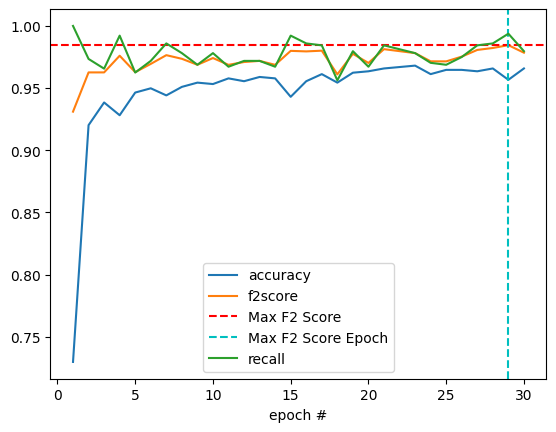

In [192]:
plt.plot(df_model_chosen_data.epoch, df_model_chosen_data.accuracy_results, label='accuracy')
plt.xlabel('epoch #')
plt.plot(df_model_chosen_data.epoch, df_model_chosen_data.f2score_results, label='f2score')
plt.axhline(y=df_model_chosen_data.f2score_results.max(), color='r', linestyle='--', label='Max F2 Score')
max_f2score_epoch = df_model_chosen_data.epoch[df_model_chosen_data.f2score_results.idxmax()]
plt.axvline(x=max_f2score_epoch, color='c', linestyle='--', label='Max F2 Score Epoch')
plt.plot(df_model_chosen_data.epoch, df_model_chosen_data.recall_results, label = 'recall')
plt.legend()
plt.show()

Even though we trained the model to optimize accuracy, as said before, this performance metric wouldn't be a good performance metric for this dataset because the data is unbalanced. A better metric to be used is F2Score.  
  
We can observe that the highest F2Score happens at epoch 29.

- Here we can test the current best model for accuracy against the test data*(not the validation data)*:

In [209]:
model, optimizer, last_epoch = load_ckp(ckp_path, model, optimizer)

In [210]:
model.eval()
perf_check_overall(model, testloader)

Recall -> 0.9750778816199377
Accuracy -> 0.9613636363636363
f2 score -> 0.9744707347447074
Accuracy of the network w/ validation/test: 96 %


(0.9613636363636363, 0.9750778816199377, 0.9744707347447074)

As we can see the returned **F2 Score is 0.9744**, which is not bad.

<a id='final'></a>
# Training the final model

[Introduction](#Introduction) [Imports](#Imports) [Helper](#Helper)  >>  
[Data](#data) [Model](#model)  [Initial Data](#initial) [Sampling Initial Data](#sampling)  >>
[Bayesian Optimization](#bayesian) [Imports BO](#imports_bo) [BO Search](#bo_search) >> [Epochs Choice](#epochs) [Final Model](#final) [Confusion Matrix](#confusion_matrix)

Now we run the model at epoch #29.

In [211]:
run_this_final = True
index_number = 56
epochs = 29

if run_this_final:

    start = time.time()  # so we start keeping track of time
    set_seeds()  # so  results are consistent.
    # Create a new model object each experiment:
    model = LeNet(conv1out      =  round(df_bo_results.iloc[index_number][2]),  # < - !!!
                  conv1kernel   =  round(df_bo_results.iloc[index_number][3]),  # < !! 
                  filter_size   =  round(df_bo_results.iloc[index_number][4]),  # < !! 
                  stride_step   =  round(df_bo_results.iloc[index_number][5]),  # < !! 
                  conv2out      =  round(df_bo_results.iloc[index_number][6]),  # < !!
                  conv2kernel   =  round(df_bo_results.iloc[index_number][7]),  # < !!
                  name          =  'LeNet5 adjustable')

    with torch.no_grad():  # trial for setting model params
        model(images)      

    # Loss and optimizer:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), 
                          lr       = df_bo_results.iloc[index_number][0],   # <  !!!
                          momentum = df_bo_results.iloc[index_number][1])   #

    accuracy_results = []  # tracking val. accuracy throught epochs
    loss_results = []
    recall_results = []
    f2score_results = []

    # The epoch loop:
    for epoch in range(epochs):  # loop over the dataset multiple times           <  - !!
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()


            if i % 100 == 99:    # print every x mini-batches
                print('[%d,%5d] loss:%.3f' %
                      (epoch + 1, i + 1, running_loss / 100), end = ' ')

                last_comp_loss_epo = running_loss / 100
                running_loss = 0.0


        print(f'\nEpoch concluded #: {epoch + 1} ', end = ' ')

        loss_results.append(last_comp_loss_epo)
        accuracy, recall, f2score =  perf_check_overall(model, valloader)  # returns: accuracy, recall
        accuracy_results.append(accuracy)  # prepare list of values
        recall_results.append(recall)      # to be returned
        f2score_results.append(f2score)    # epoch by epoch
        

    end = time.time()
    print('Finished training. Time taken: ', end-start)

# Time taken:  1256.9220094680786

LeNet5 adjustable: total params: 12092
* fc1 to be adjusted
Network has been updated:
LeNet5 adjustable: total params: 253892
LeNet(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 14, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2016, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)
[1,  100] loss:0.600 [1,  200] loss:0.531 [1,  300] loss:0.338 [1,  400] loss:0.313 [1,  500] loss:0.211 [1,  600] loss:0.198 [1,  700] loss:0.249 [1,  800] loss:0.235 [1,  900] loss:0.179 [1, 1000] loss:0.194 
Epoch concluded #: 1  Recall -> 0.984375
Accuracy -> 0.9372862029646523
f2 score -> 0.973724884080371
Accuracy of the network w/ validation/test: 93 %
[2,  100] loss:0.127 [2,  200] loss:0.174 [2,  300] loss:0.171 [2,  400] loss:0.158 [2,  500] loss:0.186 [2,  600] l

[22,  100] loss:0.000 [22,  200] loss:0.000 [22,  300] loss:0.000 [22,  400] loss:0.000 [22,  500] loss:0.000 [22,  600] loss:0.000 [22,  700] loss:0.001 [22,  800] loss:0.001 [22,  900] loss:0.000 [22, 1000] loss:0.000 
Epoch concluded #: 22  Recall -> 0.975
Accuracy -> 0.9600912200684151
f2 score -> 0.974086793630971
Accuracy of the network w/ validation/test: 96 %
[23,  100] loss:0.000 [23,  200] loss:0.000 [23,  300] loss:0.000 [23,  400] loss:0.000 [23,  500] loss:0.000 [23,  600] loss:0.000 [23,  700] loss:0.000 [23,  800] loss:0.000 [23,  900] loss:0.000 [23, 1000] loss:0.000 
Epoch concluded #: 23  Recall -> 0.975
Accuracy -> 0.9600912200684151
f2 score -> 0.974086793630971
Accuracy of the network w/ validation/test: 96 %
[24,  100] loss:0.000 [24,  200] loss:0.000 [24,  300] loss:0.000 [24,  400] loss:0.000 [24,  500] loss:0.000 [24,  600] loss:0.000 [24,  700] loss:0.000 [24,  800] loss:0.000 [24,  900] loss:0.000 [24, 1000] loss:0.000 
Epoch concluded #: 24  Recall -> 0.975


Now we can save or load the data depending on whether last cell was run:

In [212]:
if run_this_final:  # save the final model w/ best val. accuracy
    checkpoint = {
        'epoch': epoch,  # or epoch + 1
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }

    is_best = True # it is the best so it will copy to model_best folder
    checkpoint_dir = './models_f2'
    best_model_dir = './model_best_f2'

    save_ckp(checkpoint, is_best, checkpoint_dir, best_model_dir)
    
else:  # load best model:
    model = LeNet(conv1out      =  round(df_bo_results.iloc[23][2]),  # < - !!!
                  conv1kernel   =  round(df_bo_results.iloc[23][3]),  # < !! 
                  filter_size   =  round(df_bo_results.iloc[23][4]),  # < !! 
                  stride_step   =  round(df_bo_results.iloc[23][5]),  # < !! 
                  conv2out      =  round(df_bo_results.iloc[23][6]),  # < !!
                  conv2kernel   =  round(df_bo_results.iloc[23][7]),  # < !!
                  name          =  'LeNet5 adjustable')
    with torch.no_grad():  # trial for setting model params
        model(images) 
    
    criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.SGD(model.parameters(), 
                          lr       = df_bo_results.iloc[23][0],   # <  !!!
                          momentum = df_bo_results.iloc[23][1])   #
    
    
    ckp_path = './model_best_f2/best_model.pt'
    
    model, optimizer, last_epoch = load_ckp(ckp_path, model, optimizer)

In [217]:
epo_list = np.arange(1,30)
df_epoch_data = pd.DataFrame({'epoch':epo_list, 
                                     #'loss_results':loss_results, 
                                     'accuracy_results':accuracy_results,
                                     'f2score_results':f2score_results,
                                     'recall_results':recall_results
                                    })

**Testing chosen model for accuracy against test data:**

In [219]:
model.eval()
perf_check_overall(model, testloader)


Recall -> 0.9797507788161994
Accuracy -> 0.9647727272727272
f2 score -> 0.9782270606531881
Accuracy of the network w/ validation/test: 96 %


(0.9647727272727272, 0.9797507788161994, 0.9782270606531881)

- Model has 96.47% accuracy with test data, and F2Score of 0.97, Recall rate 0.97.

<a id='confusion_matrix'></a>
## Confusion Matrix

[Introduction](#Introduction) [Imports](#Imports) [Helper](#Helper)  >>  
[Data](#data) [Model](#model)  [Initial Data](#initial) [Sampling Initial Data](#sampling)  >>
[Bayesian Optimization](#bayesian) [Imports BO](#imports_bo) [BO Search](#bo_search) >> [Epochs Choice](#epochs) [Final Model](#final) [Confusion Matrix](#confusion_matrix)

Running predictions on test dataset:

In [254]:
correct = 0
total = 0
labels_all_test = torch.Tensor()
outputs_all_test = torch.Tensor()
with torch.no_grad():
        for data in testloader:
            images, labels = data
            labels_all_test = torch.cat((labels_all_test,labels))
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            outputs_all_test = torch.cat((outputs_all_test,predicted))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

Now, on validation dataset:

In [258]:
correct = 0
total = 0
labels_all_val = torch.Tensor()
outputs_all_val = torch.Tensor()
with torch.no_grad():
        for data in valloader:
            images, labels = data
            labels_all_val = torch.cat((labels_all_val,labels))
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            outputs_all_val = torch.cat((outputs_all_val,predicted))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

In [259]:
# labels_all == outputs_all

In [260]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Generating Confusion Matrix according to predictions:

In [282]:
cm_val = confusion_matrix(labels_all_val, outputs_all_val)  # true, pred
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=data_train.class_to_idx)

cm_test = confusion_matrix(labels_all_test, outputs_all_test)  # true, pred
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=data_train.class_to_idx)

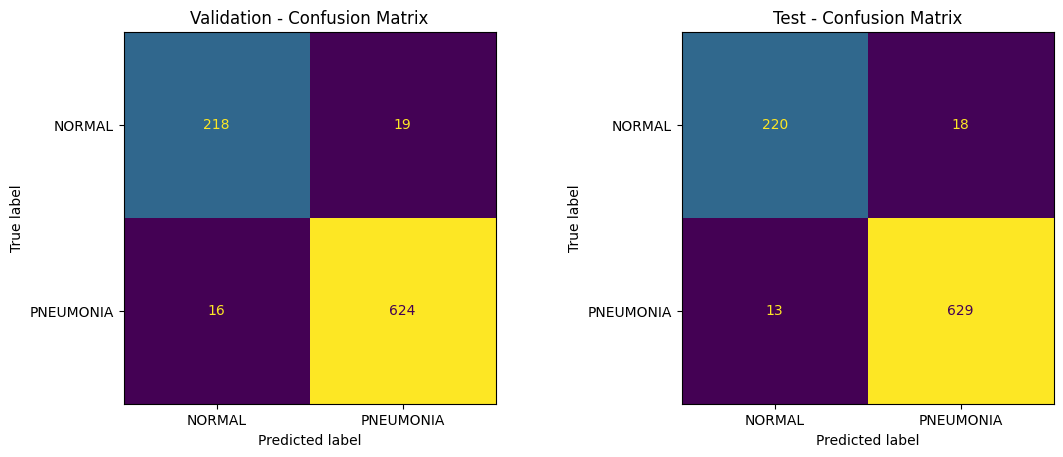

In [281]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=data_train.class_to_idx)
disp_val.plot(ax=ax1,colorbar = False)
ax1.set_title('Validation - Confusion Matrix')

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=data_train.class_to_idx)
disp_test.plot(ax=ax2, colorbar = False)
ax2.set_title('Test - Confusion Matrix')

plt.subplots_adjust(wspace=0.5)
plt.show()


In this kind of problem the type of error plays a role in the usefulness of the model, and how it could be applied in a real world task. So it is necessary to consider two types of errors:

> **False Positive (Type 1 Error):** You predicted positive and it’s false. You predicted that animal is a cat but it actually is not (it’s a dog).  
> **False Negative (Type 2 Error):** You predicted negative and it’s false. You predicted that animal is not a cat but it actually is.

In this case of a medical environment, having to choose the kind of error that the model can be optimized for, what would be the proper choice? If you classify a patient as 'normal', when in fact, he has pneumonia, he won't be able to get appropriate treatment. However, suppose you classify a patient as positive for 'pneumonia'. In that case, he will get through to a doctor to do further investigations on that particular case and conclude if the patient has pneumonia.  

So, in this case, the proper course of action would be to minimize False Negatives(Type 2 error). Telling a patient he does not have a condition when he has will prevent further medical investigation into his case.

In this context, Recall is an important metric, and it is defined as the ratio of the total number of correctly classified positive classes divided by the total number of positive classes.
$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}$$


In [286]:
recall_test = recall_score(labels_all_test, outputs_all_test)
f2score_test = fbeta_score(labels_all_test, outputs_all_test, beta=2)
print(f'Recall test dataset: {recall_test}')
print(f'F2Score test dataset: {f2score_test}')

Recall test dataset: 0.9797507788161994
F2Score test dataset: 0.9782270606531881


As we can see, for the Recall metric(629 / (629+13) ), we correctly identified almost 98% of patients that were sick as sick, leaving roughly 2% misdiagnosed. In this context, in a review cycle for this work, the Recall performance should be prioritized to achieve 100%, even though it might mean getting more errors type 1.  

On the other hand, F-Score is a measurement that combines both Precision and Recall; by setting F to 2, we will give more importance to Recall.

$$F_\beta = \frac{(1 + \beta^2) \cdot \text{Precision} \cdot \text{Recall}}{(\beta^2 \cdot \text{Precision}) + \text{Recall}}$$


>*Fβ-score Formula Symbol*  
>A factor indicating how much more important recall is than precision. For example, if we consider recall to be twice as important as precision, we can set β to 2. The standard F-score is equivalent to setting β to one.[1](https://deepai.org/machine-learning-glossary-and-terms/f-score)  
  
We can check that the F2Score is compatible with the Recall Score. The results obtained were similar when giving the recall score twice the importance over the Precision metrics. The advantage of F2Score is that it will consider the Precision as well, making sure we are not getting a good Recall measurement just because we are classifying everything as positive, and just because of that getting a good recall.

# Conclusion

In this data project centred around X-ray image classification for medical diagnosis, Bayesian optimization has been widely used in achieving exceptional results. By combining Bayesian optimization with BoTorch Trust Region Search, we enhanced the performance of our LeNet5-based CNN model.

Bayesian optimization is a powerful technique that excels in scenarios where the objective function is costly to evaluate, as is often the case in complex machine learning models. It leverages a probabilistic model to intelligently explore the hyperparameter space, making informed decisions about which configurations to try next. This capability becomes crucial when training deep learning models, which typically require significant computational resources and time.

In this project, Bayesian optimization played a vital role in fine-tuning hyperparameters to maximize the optimization metric. This should be considered an initial work for reviewing. The focus for the following review should be minimizing Type 2 errors. This will reduce the risk of missing positive cases during diagnoses, ultimately improving patient outcomes and healthcare efficiency.

Botorch provided a flexible and modular platform for implementing Bayesian optimization algorithms. At the same time, trust region search efficiently explored the search space yielding better results with less computational power.

The Recall score of approximately 0.98 achieved in our project demonstrates the efficacy of Bayesian optimization in optimizing the model's performance for medical diagnosis tasks. However, there is always room for improvement. Exploring additional hyperparameter configurations and incorporating more sophisticated models into the optimization pipeline may yield even better results in future iterations.

Bayesian optimization was a critical component of this project, playing a key role in fine-tuning hyperparameters and achieving exceptional metrics. Its ability to optimize complex models in computationally efficient ways proved instrumental in creating a robust and reliable X-ray image classification system for medical diagnosis. Leveraging the power of Bayesian optimization, the model will continue to evolve, ultimately leading to better metrics.